Total records in sfrs (before filtering by image/spectrum): 4851200
Total records after filtering by image/spectrum availability: 151190
Total records after removing NaN in AVG: 34613
Total records after filtering AVG >= -80: 30752
Among them, FLAG == 0: 16841


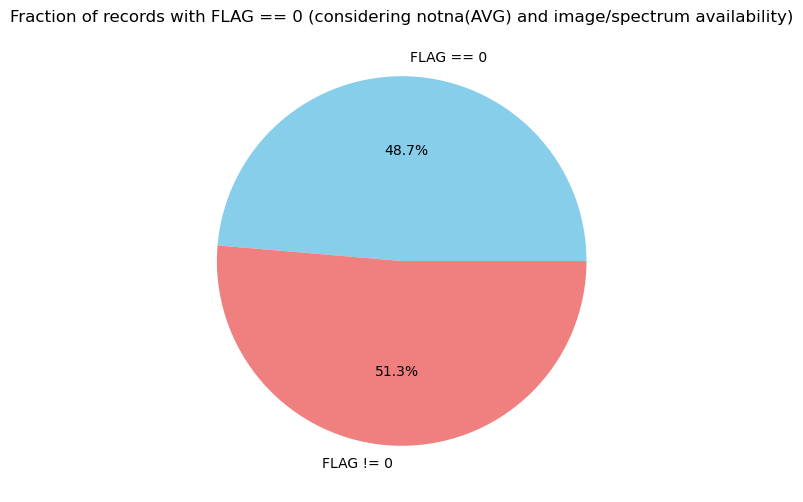

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Data paths
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"

# -------------------------
# 1) Loading SFR data and filtering based on image and spectrum availability
# Load the SFR table
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
print("Total records in sfrs (before filtering by image/spectrum):", len(sfrs))

# Load metadata from the spectral cube
with h5py.File(CUBE_PATH, "r") as cube:
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]
# Extract object indices (e.g., 'ds_slice_idx')
metadata_indices = metadata[:, 0]["ds_slice_idx"]

# Filter the sfrs table, keeping only the records that have data in the cube
sfrs = sfrs[sfrs.index.isin(metadata_indices)].copy()
print("Total records after filtering by image/spectrum availability:", len(sfrs))

# Remove rows where AVG is NaN (missing SFR value)
sfrs = sfrs[sfrs["AVG"].notna()].copy()
print("Total records after removing NaN in AVG:", len(sfrs))

# Filter by threshold AVG >= -80 (or another threshold)
sfrs_filtered = sfrs[sfrs["AVG"] >= -80].copy()
print("Total records after filtering AVG >= -80:", len(sfrs_filtered))

# Select the subset with FLAG == 0
sfrs_flag0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] == 0.0].copy()
print("Among them, FLAG == 0:", len(sfrs_flag0_filtered))

# -------------------------
# 2) Visualizing the fraction of FLAG == 0 records
sfrs_flag0 = sfrs[sfrs["FLAG"] == 0.0]
labels_pie = ["FLAG == 0", "FLAG != 0"]
sizes = [len(sfrs_flag0), len(sfrs) - len(sfrs_flag0)]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels_pie, autopct='%1.1f%%', colors=["skyblue", "lightcoral"])
plt.title("Fraction of records with FLAG == 0 (considering notna(AVG) and image/spectrum availability)")
plt.show()

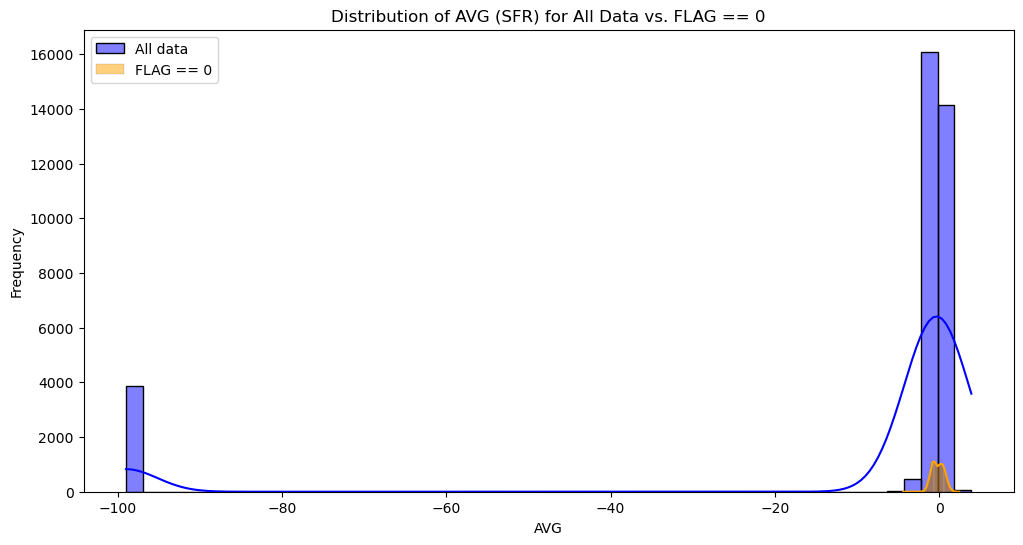

In [8]:
# -------------------------
# 3) Visualizing the distribution of AVG (SFR)
plt.figure(figsize=(12,6))
sns.histplot(sfrs["AVG"].dropna(), bins=50, color="blue", label="All data", kde=True)
sns.histplot(sfrs_flag0["AVG"].dropna(), bins=50, color="orange", label="FLAG == 0", kde=True)
plt.legend()
plt.title("Distribution of AVG (SFR) for All Data vs. FLAG == 0")
plt.xlabel("AVG")
plt.ylabel("Frequency")
plt.show()

After filtering AVG>=-80: total 30752, among them FLAG==0: 16841


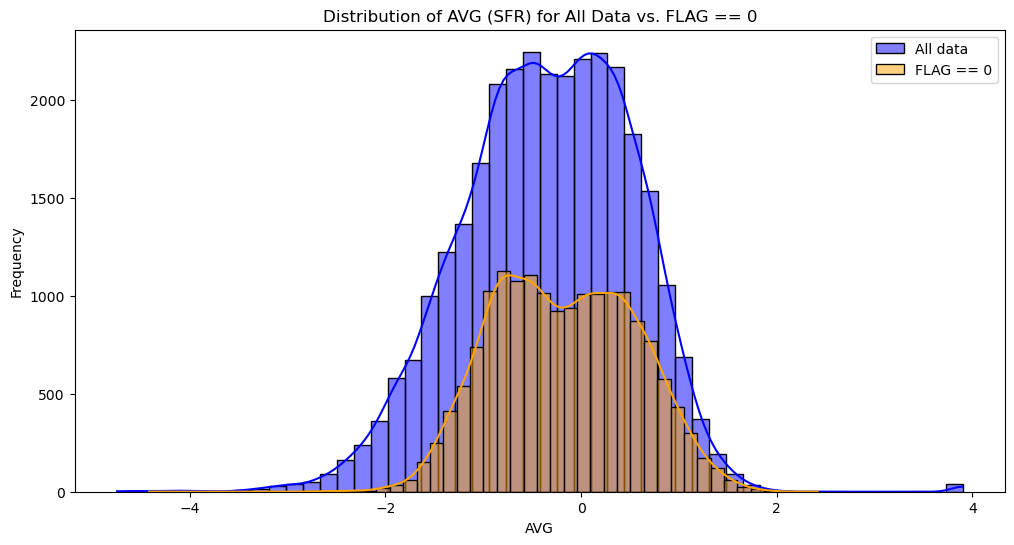

In [3]:
sfrs_filtered = sfrs[sfrs["AVG"] >= -80].copy()
sfrs_flag0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] == 0.0].copy()

print(f"After filtering AVG>=-80: total {len(sfrs_filtered)}, among them FLAG==0: {len(sfrs_flag0_filtered)}")

plt.figure(figsize=(12,6))
sns.histplot(sfrs_filtered["AVG"].dropna(), bins=50, color="blue", label="All data", kde=True)
sns.histplot(sfrs_flag0_filtered["AVG"].dropna(), bins=50, color="orange", label="FLAG == 0", kde=True)
plt.legend()
plt.title("Distribution of AVG (SFR) for All Data vs. FLAG == 0")
plt.xlabel("AVG")
plt.ylabel("Frequency")
plt.show()

In [4]:
# -------------------------
# 4) Working with NaN percentages in spectra (All vs. FLAG==0)

# Load spectral data for all 4 zoom levels
# Create masks based on the filtered SFR table indices
mask_all = np.in1d(metadata_indices, sfrs_filtered.index)       # All records with AVG >= -80
mask_flag0 = np.in1d(metadata_indices, sfrs_flag0_filtered.index)  # Records with FLAG==0 and AVG >= -80

spectra_all_list = []
spectra_flag0_list = []
for zoom in range(4):
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    with h5py.File(CUBE_PATH, "r") as cube:
        spec_data = cube[spec_key][:]  # Load all spectra at this zoom level
    # Filter spectra by masks
    spec_data_all = spec_data[mask_all]
    spec_data_flag0 = spec_data[mask_flag0]
    spectra_all_list.append(spec_data_all)
    spectra_flag0_list.append(spec_data_flag0)

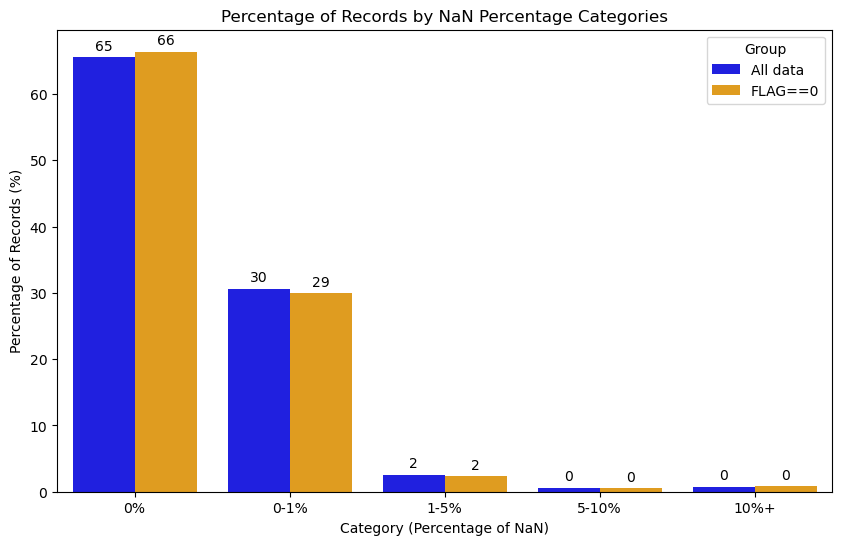

In [5]:

nan_counts_all = np.sum(np.isnan(spectra_all_list[0]), axis=1)
nan_counts_flag0 = np.sum(np.isnan(spectra_flag0_list[0]), axis=1)
total_length = spectra_all_list[0].shape[1]

def categorize_nan_percentage(nan_counts, total_length):
    """
    Converts the absolute number of NaNs into a percentage of the spectrum length
    and returns string categories:
      - "0%" if 0% NaNs,
      - "0-1%" if up to 1%,
      - "1-5%" if up to 5%,
      - "5-10%" if up to 10%,
      - "10%+" if more than 10%.
    """
    percentages = (nan_counts / total_length) * 100
    categories = []
    for p in percentages:
        if p == 0:
            categories.append("0%")
        elif p <= 1:
            categories.append("0-1%")
        elif p <= 5:
            categories.append("1-5%")
        elif p <= 10:
            categories.append("5-10%")
        else:
            categories.append("10%+")
    return categories

# Apply the function for all data and for FLAG==0
categories_all = categorize_nan_percentage(nan_counts_all, total_length)
categories_flag0 = categorize_nan_percentage(nan_counts_flag0, total_length)

# Create DataFrames for convenience
df_all = pd.DataFrame({"NaN_Category": categories_all, "Group": "All data"})
df_flag0 = pd.DataFrame({"NaN_Category": categories_flag0, "Group": "FLAG==0"})
df = pd.concat([df_all, df_flag0], ignore_index=True)

# Define the order of categories (percentage ranges)
category_order = ["0%", "0-1%", "1-5%", "5-10%", "10%+"]

# Group data by Group and NaN_Category to count the number of records
grouped = df.groupby(["Group", "NaN_Category"]).size().reset_index(name="count")
total_counts = df.groupby("Group").size().reset_index(name="total")
merged = pd.merge(grouped, total_counts, on="Group")
merged["percent"] = merged["count"] / merged["total"] * 100

# Convert NaN_Category to an ordered categorical type and sort by it
merged["NaN_Category"] = pd.Categorical(merged["NaN_Category"], categories=category_order, ordered=True)
merged = merged.sort_values(["Group", "NaN_Category"])

# Plot a bar chart with percentages using bright colors (blue and orange)
plt.figure(figsize=(10,6))
ax = sns.barplot(data=merged, x="NaN_Category", y="percent", hue="Group", 
                 order=category_order, palette=["blue", "orange"])
plt.title("Percentage of Records by NaN Percentage Categories")
plt.xlabel("Category (Percentage of NaN)")
plt.ylabel("Percentage of Records (%)")

# Add annotations (number of records) above each bar.
# Using the built-in bar_label method (Matplotlib >= 3.4)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.show()

Zoom level 0: found 24076 NaN blocks, average length = 31.97, maximum = 4620
Zoom level 1: found 23793 NaN blocks, average length = 16.70, maximum = 2310
Zoom level 2: found 23621 NaN blocks, average length = 8.96, maximum = 1155
Zoom level 3: found 23448 NaN blocks, average length = 5.11, maximum = 577


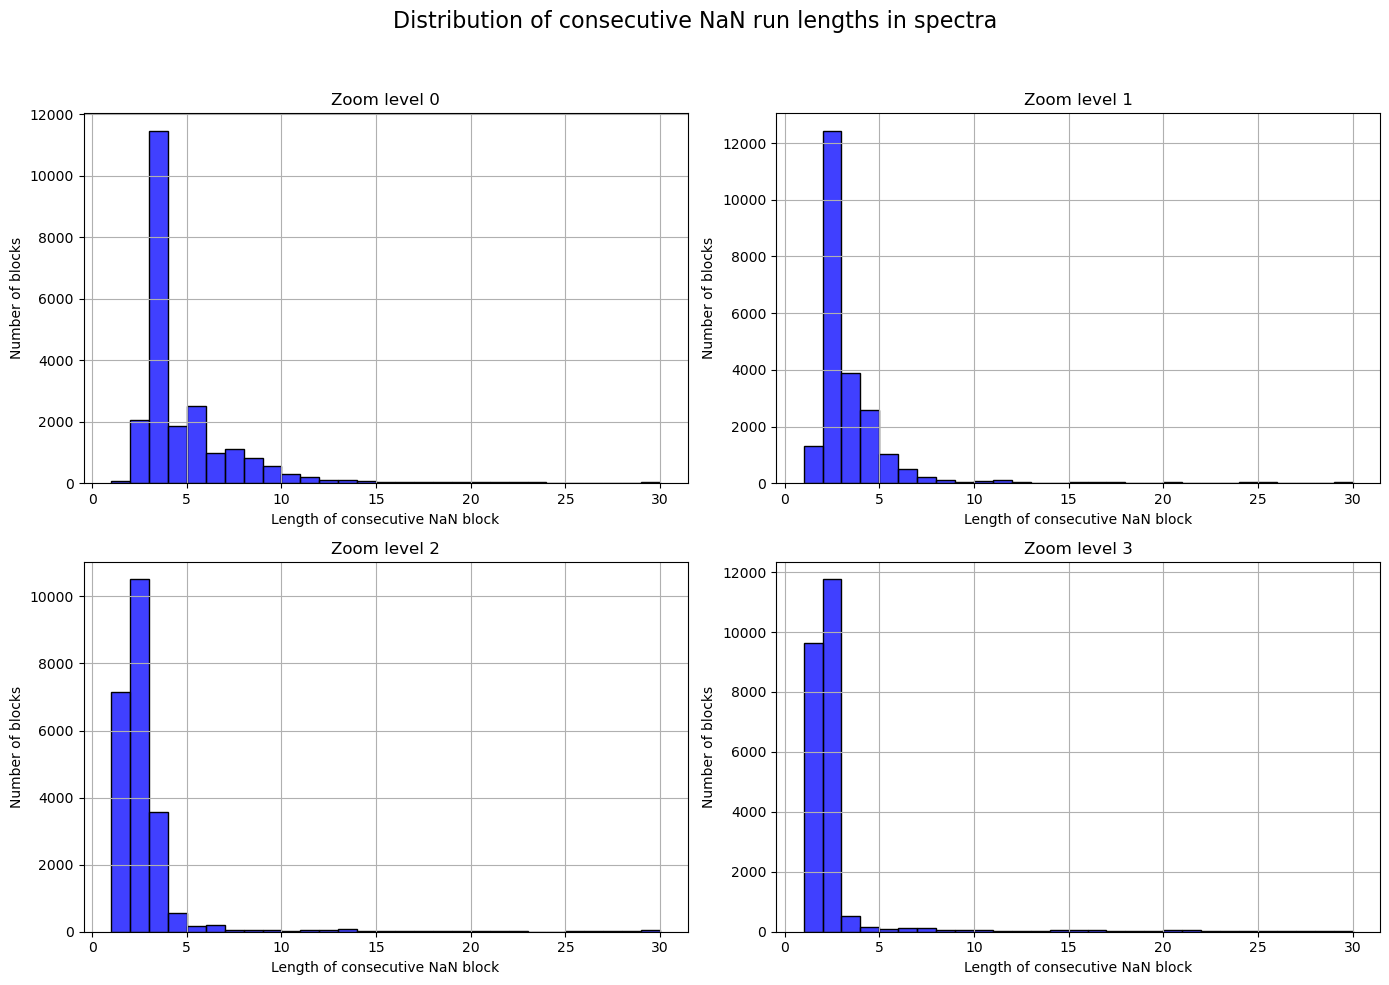

In [6]:
def get_run_lengths(bool_arr):
    """
    Takes a boolean array and returns an array of lengths of consecutive True blocks.
    For example, for [False, True, True, False, True] it returns [2, 1].
    """
    # Convert the boolean array to int and add a 0 at both ends
    diff = np.diff(np.concatenate(([0], bool_arr.astype(int), [0])))
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    return ends - starts

# For each zoom level (0, 1, 2, 3), collect all run lengths of consecutive NaNs
run_lengths_by_zoom = []
for zoom in range(4):
    runs = []
    # spectra_all_list[zoom] is an array of spectra for the given zoom level, shape (N, L)
    for row in spectra_all_list[zoom]:
        bool_nan = np.isnan(row)
        # Get the array of lengths of consecutive True values (NaNs)
        run_lengths = get_run_lengths(bool_nan)
        # If the spectrum has no NaNs, run_lengths will be empty; then skip
        if run_lengths.size > 0:
            runs.extend(run_lengths)
    run_lengths_by_zoom.append(np.array(runs))
    print(f"Zoom level {zoom}: found {len(runs)} NaN blocks, average length = {np.mean(runs) if len(runs)>0 else 0:.2f}, maximum = {np.max(runs) if len(runs)>0 else 0}")

# Plot histograms of the run lengths of NaN blocks for each zoom level
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()
bins = np.arange(1, 31)  # e.g., show lengths from 1 to 30 (adjust as needed)

for i in range(4):
    sns.histplot(run_lengths_by_zoom[i], bins=bins, ax=axes[i], color="blue", kde=False)
    axes[i].set_title(f"Zoom level {i}")
    axes[i].set_xlabel("Length of consecutive NaN block")
    axes[i].set_ylabel("Number of blocks")
    axes[i].grid(True)

plt.suptitle("Distribution of consecutive NaN run lengths in spectra", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


/tmp/ipykernel_3199553/3622171378.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_orig, x="TARGETTYPE", palette="viridis")
/tmp/ipykernel_3199553/3622171378.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_simpl, x="Simplified_TARGETTYPE", palette="viridis")


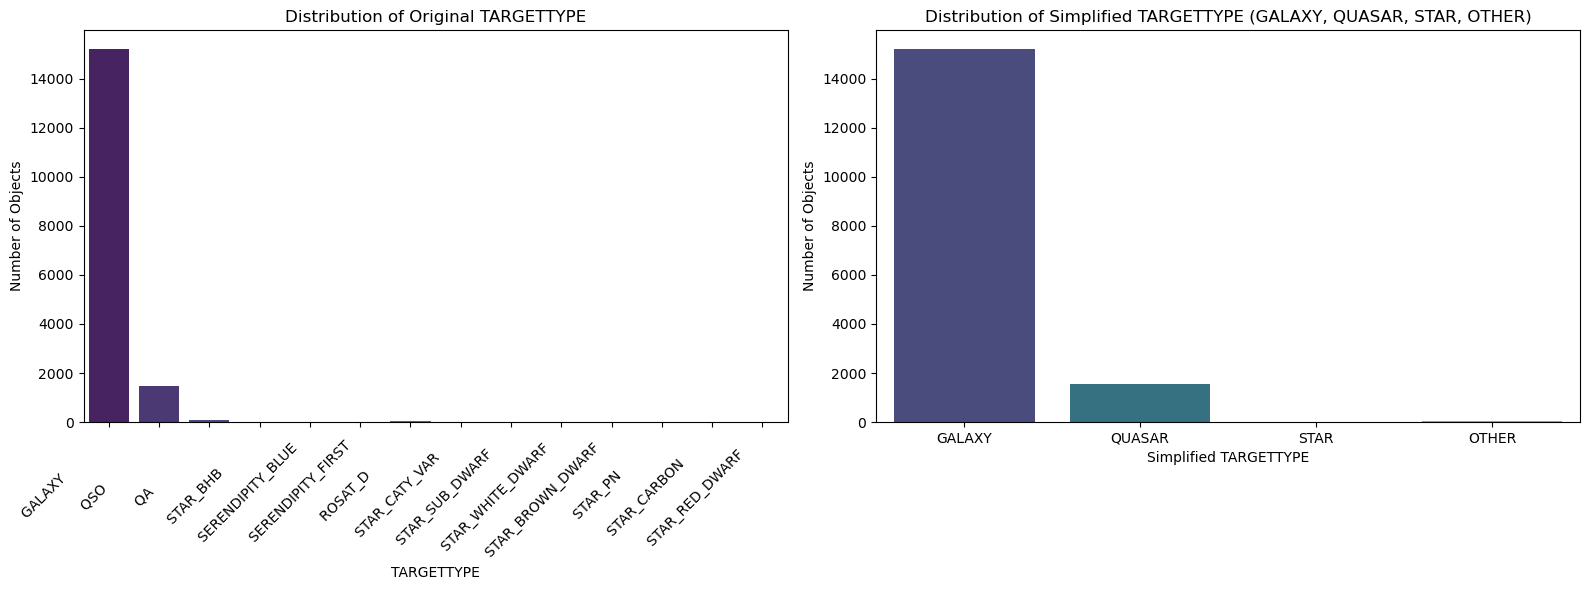

In [7]:
# Load the TARGETTYPE labels from the filtered FLAG==0 dataset
labels = sfrs_flag0_filtered.loc[:, "TARGETTYPE"]

def simplify_targettype(val):
    """
    Simplifies the TARGETTYPE value.
    Decodes bytes to string and trims whitespace.
    Returns:
      - "GALAXY" if "GALAXY" is in the value,
      - "QUASAR" if "QSO" or "QA" is in the value,
      - "STAR" if "STAR" is in the value,
      - "OTHER" otherwise.
    """
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    if "GALAXY" in val:
        return "GALAXY"
    elif "QSO" in val or "QA" in val:
        return "QUASAR"
    elif "STAR" in val:
        return "STAR"
    else:
        return "OTHER"

# Convert the labels to DataFrames for plotting
df_orig = pd.DataFrame({"TARGETTYPE": labels})
df_simpl = pd.DataFrame({"Simplified_TARGETTYPE": pd.Series(labels).apply(simplify_targettype)})

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.countplot(data=df_orig, x="TARGETTYPE", palette="viridis")
plt.title("Distribution of Original TARGETTYPE")
plt.xlabel("TARGETTYPE")
plt.ylabel("Number of Objects")
plt.xticks(rotation=45, ha="right")

plt.subplot(1, 2, 2)
sns.countplot(data=df_simpl, x="Simplified_TARGETTYPE", palette="viridis")
plt.title("Distribution of Simplified TARGETTYPE (GALAXY, QUASAR, STAR, OTHER)")
plt.xlabel("Simplified TARGETTYPE")
plt.ylabel("Number of Objects")

plt.tight_layout()
plt.show()